In [1]:
# Importing useful libraries
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd
import datetime
import plotly.express as px
import seaborn as sns
import time
import re
from datetime import timedelta

## Author Data (from "lighter_authors.json"):


id: A unique identifier for the author.
    
name: The name of the author.

gender: The gender of the author.

image_url: URL to an image of the author.

about: A description or biography of the author.

fans_count: The count of fans or followers of the author on the platform.


## Book Data (from "lighter_books.json"):


id: A unique identifier for the book.

title: The title of the book.

authors: A list of authors associated with the book, where each author includes an id, name, and role (e.g., author, illustrator).

isbn: ISBN (International Standard Book Number) of the book.

isbn13: ISBN-13 of the book.

asin: Amazon Standard Identification Number, if applicable.

language: The language of the book.

average_rating: The average rating given by readers.

rating_dist: Distribution of ratings (e.g., the number of 5-star, 4-star, etc., ratings).

ratings_count: The total count of ratings for the book.

text_reviews_count: The count of written text reviews for the book.

publication_date: The publication date of the book.

original_publication_date: The original publication date of the book.

format: The format in which the book is available (e.g., Paperback).

edition_information: Information about the edition of the book.

image_url: URL to an image of the book.

publisher: The publisher of the book.

num_pages: The number of pages in the book.

series_id: A unique identifier for the series to which the book belongs.

series_name: The name of the series to which the book belongs.

series_position: The position of the book within the series.

shelves: A list of shelves or categories where the book is categorized, with counts.

In [3]:
# Importing the first dataset "author" in a dataframe called authors to work on it

file_path_authors = ".\lighter_authors.json"
ch_size = 100
dfs = []

chunks = pd.read_json(file_path_authors, lines = True, chunksize=1000)

# Read columns' names
for chunk in chunks:
    chunk.info()
    break

with open(file_path_authors, "r") as file:
    for ch in pd.read_json(file, lines = True, chunksize = 1000):
        dfs.append(ch)

authors = pd.concat(dfs, ignore_index = True)

authors.head(10)

authors.shape # authors dataset has 351767 rows and 12 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ratings_count       1000 non-null   int64  
 1   average_rating      1000 non-null   float64
 2   text_reviews_count  1000 non-null   int64  
 3   work_ids            1000 non-null   object 
 4   book_ids            1000 non-null   object 
 5   works_count         1000 non-null   int64  
 6   id                  1000 non-null   int64  
 7   name                1000 non-null   object 
 8   gender              1000 non-null   object 
 9   image_url           1000 non-null   object 
 10  about               1000 non-null   object 
 11  fans_count          1000 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 93.9+ KB


(351767, 12)

In [4]:
chunks = pd.read_json("./lighter_books.json", lines = True, chunksize=1000)

good_columns  = []  # list with the columns' names

for chunk in chunks:
    good_columns  = chunk.columns.tolist()
    break

# print(good_columns)

# Importing only the interesting columns from the dataset "books" to solve the exercise

file_path_books = "./lighter_books.json"
ch_size = 10000
dfs = []

with open(file_path_books, "r") as file:
    for ch in pd.read_json(file, lines = True, chunksize = 1000):
        ch = ch[["id", "title", "author_id", "author_name", "series_name", "series_id", "series_position", "format",
                "original_publication_date", "work_id", "average_rating", "text_reviews_count", "language","rating_dist",
                "ratings_count", "publication_date", "edition_information","publisher","num_pages"]]
        # selecting only the useful columns
        dfs.append(ch)


books = pd.concat(dfs, ignore_index = True)

In [97]:
books_cleaned = books.drop_duplicates(subset=['title', 'author_id', 'series_id', 'series_position'], keep = "first")
books_cleaned = books_cleaned.drop_duplicates(subset = ['work_id'])
books_cleaned = books_cleaned[books_cleaned['title'] != ""]
books_cleaned = books_cleaned[books_cleaned['author_id'] != ""]
books_cleaned = books_cleaned[books_cleaned['author_name'] != "NOT A BOOK"]
books_cleaned = books_cleaned[books_cleaned['author_name'] != "Unknown"]
books_cleaned = books_cleaned[books_cleaned['author_name'] != "Source Wikipedia"]
books_cleaned = books_cleaned[books_cleaned['author_name'] != "Various"]
books_cleaned = books_cleaned[books_cleaned['author_name'] != "Anonymous"]

print(authors.shape[0])
x = ['', 'NOT A BOOK', 'Unknown', 'Source Wikipedia', 'Various', 'Anonymous']
authors = authors[authors['name'].isin(x) == False]
print(authors.shape[0])


351767
351762


In [6]:
print(books.shape[0])
print(books_cleaned.shape[0])

7027431
2459484


## [RQ1] Exploratory Data Analysis (EDA) - Before working on your research questions, you should provide meaningful statistical summaries through visualizations and tabular tools to understand your data.

In [7]:
# Basic statistics for authors
author_summary = authors.describe()
author_summary

,ratings_count,average_rating,text_reviews_count,works_count,id,fans_count
count,3.517670e+05,351767.000000,351767.000000,3.517670e+05,3.517670e+05,351767.000000
mean,4.770586e+03,3.651194,330.993243,2.593714e+01,7.751861e+06,111.615731
std,9.769395e+04,1.211482,3857.539191,3.066083e+03,6.578409e+06,2661.018139
min,-4.100000e+01,-31.000000,0.000000,0.000000e+00,4.000000e+00,-33.000000
25%,6.000000e+00,3.600000,1.000000,2.000000e+00,1.535315e+06,1.000000
50%,3.900000e+01,3.950000,8.000000,6.000000e+00,6.470396e+06,4.000000
75%,3.100000e+02,4.250000,53.000000,1.500000e+01,1.434041e+07,20.000000
max,2.700375e+07,5.000000,608956.000000,1.775176e+06,2.124802e+07,766035.000000


In [8]:
# Basic statistics for books
book_summary = books_cleaned.describe()
book_summary

,id,author_id,work_id,average_rating,text_reviews_count,ratings_count
count,2.459484e+06,2.459484e+06,2.459484e+06,2.459484e+06,2.459484e+06,2.459484e+06
mean,1.164566e+07,2.673185e+06,1.985474e+07,2.809885e+00,2.894237e+01,4.769196e+02
std,8.097010e+06,3.597670e+06,1.616304e+07,1.816108e+00,5.502674e+02,1.563627e+04
min,2.000000e+00,4.000000e+00,6.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.270245e+06,9.303400e+04,4.011426e+06,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.223673e+07,7.413640e+05,1.900795e+07,3.650000e+00,0.000000e+00,4.000000e+00
75%,1.832369e+07,4.868766e+06,2.717554e+07,4.080000e+00,3.000000e+00,2.800000e+01
max,2.552102e+07,2.124802e+07,8.972161e+07,5.000000e+00,1.728090e+05,7.377351e+06


In [10]:
authors.isnull().sum()
books_cleaned.isnull().sum()

id                           0
title                        0
author_id                    0
author_name                  0
series_name                  0
series_id                    0
series_position              0
format                       0
original_publication_date    0
work_id                      0
average_rating               0
text_reviews_count           0
language                     0
rating_dist                  0
ratings_count                0
publication_date             0
edition_information          0
publisher                    0
num_pages                    0
dtype: int64

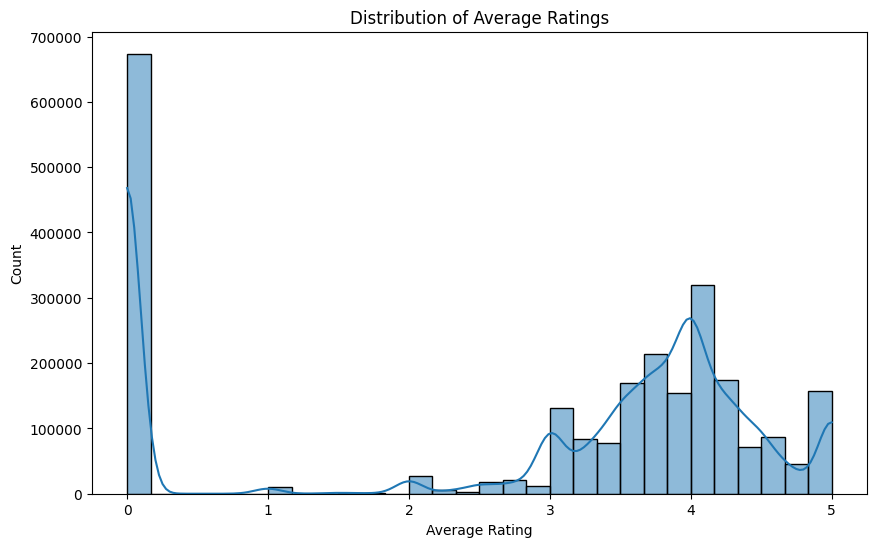

In [14]:
# 2. Visualizations
# distribution of average ratings
plt.figure(figsize=(10, 6))
sns.histplot(books_cleaned['average_rating'], bins=30, kde=True)
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

From this histogram, we can understand that most books have a rating equal to 0. However, we need to investigate to understand why this is the case, as it appears very unusual. Let's examine the reasons behind this.

In [22]:
books_cleaned[books_cleaned['average_rating'] == 0].shape[0]

673753

In [24]:
books_cleaned[(books_cleaned['average_rating'] == 0) & (books_cleaned['ratings_count'] == 0)].shape[0]

673753

From the codes above, we found that there are 673,753 books with an 'average_rating' equal to 0. However, the reason behind this anomaly is that all of these books do not have reviews. Therefore, let's plot the 'average_rating' histogram again, excluding these rows.

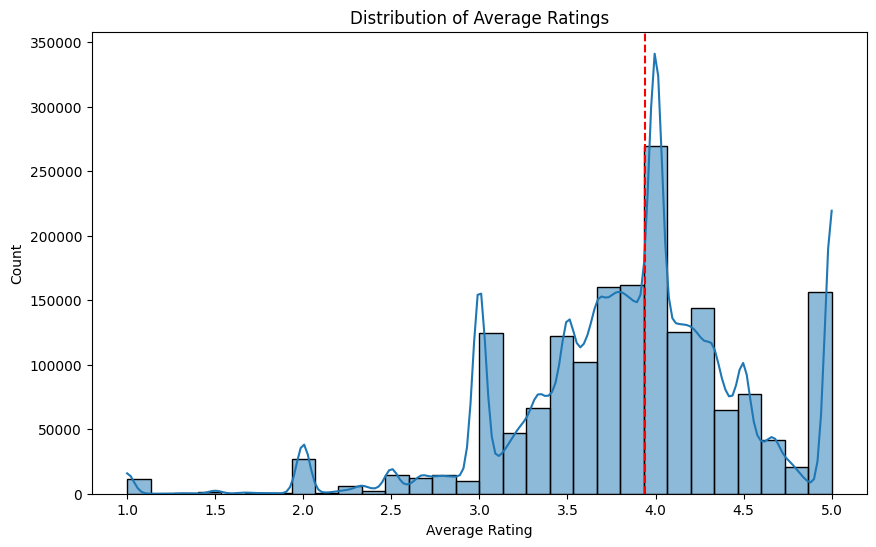

In [27]:
new_df = books_cleaned[~((books_cleaned['average_rating'] == 0) & (books_cleaned['ratings_count'] == 0))]

median = np.median(new_df['average_rating'])

plt.figure(figsize=(10, 6))
sns.histplot(new_df['average_rating'], bins=30, kde=True)
plt.axvline(x=median, color='red', linestyle='dashed') # plot median

plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.show()

We can see that the distribution is very skewed, with a long tail to the right. This means that there are many books with high ratings, while books with low ratings are relatively rare.

The modal class for the distribution is [3.9, 4.1] and the median is exaclty 3.9.

,average_rating,ratings_count,text_reviews_count,num_pages
5,4.73,31142,975,
12,3.73,79,4,
14,4.35,770,33,
16,4.37,741,29,
35,4.76,6037,57,
...,...,...,...,...
7027391,5.00,1,0,
7027409,4.00,1,0,
7027412,4.08,3698,373,
7027415,4.31,13,1,


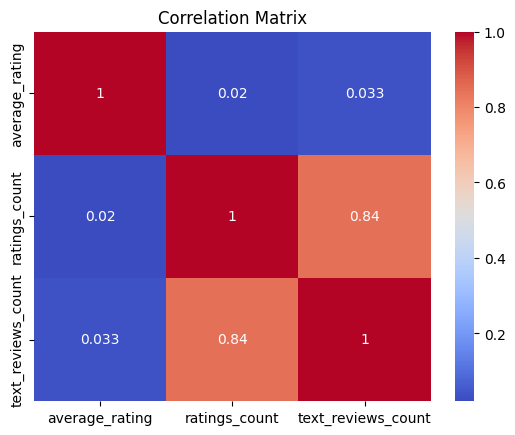

In [42]:
# 3. Explore correlations between variables, selecting only interesting variables
df_corr = books_cleaned[['average_rating', 'ratings_count', 'text_reviews_count']]
correlation_matrix = df_corr.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [44]:
# 4. Investigate the top authors by the number of works
top_authors = authors.sort_values(by='works_count', ascending=False).head(10)
top_authors

,ratings_count,average_rating,text_reviews_count,work_ids,book_ids,works_count,id,name,gender,image_url,about,fans_count
83322,115710,4.07,9411,"[45100209, 3628, 1507439, 85644185, 24676995, ...","[25357793, 530270, 1515734, 54883522, 17673542...",1775176,1000834,NOT A BOOK,,https://s.gr-assets.com/assets/nophoto/user/u_...,This profile was created to segregate those it...,4504
213945,8510,4.02,527,"[21723362, 22939358, 22945924, 22579311, 22982...","[15971714, 16706030, 16712573, 16392251, 16739...",186086,5823409,Jesse Russell,male,https://s.gr-assets.com/assets/nophoto/user/m_...,"Bookvika Publishing, VSD, Book on Demand Ltd —...",164
155912,8896,4.03,603,"[45374727, 42340520, 64602098, 26803594, 64492...","[25573859, 22795625, 41384870, 18855820, 41284...",186047,3393273,Ronald Cohn,male,https://s.gr-assets.com/assets/nophoto/user/m_...,"Bookvika Publishing, VSD, Book on Demand Ltd —...",31
198315,1434041,4.15,78830,"[6405906, 2139868, 3802528, 19119100, 859375, ...","[1923820, 323355, 19351, 280111, 93101, 646462...",182675,5158478,Anonymous,,https://s.gr-assets.com/assets/nophoto/user/u_...,"Books can be attributed to ""Anonymous"" for sev...",2456
187134,431204,3.58,18883,"[189503, 2954048, 15068023, 477, 370900, 11453...","[52357, 3049, 23613, 73419, 381112, 18261, 100...",163434,4699102,Unknown,,https://s.gr-assets.com/assets/nophoto/user/u_...,"Books can be attributed to ""Unknown"" when the ...",1067
198175,12245,4.24,402,"[17594822, 14856254, 14149404, 17788235, 18149...","[12583816, 9962321, 8882037, 12673086, 1298938...",120379,5153555,Source Wikipedia,,https://s.gr-assets.com/assets/nophoto/user/u_...,Source Wikipedia is a compiler and publisher o...,143
207023,332569,4.00,32470,"[42863273, 22314408, 74837230, 47301079, 59548...","[23308785, 16268895, 49583273, 27251758, 37851...",79378,5481957,Various,,https://s.gr-assets.com/assets/nophoto/user/u_...,Various is the correct author for any book wit...,898
2665,389,4.23,33,"[1435582, 23125635, 1190378, 2905152, 1574687,...","[687877, 16859302, 1202214, 2878966, 1581839, ...",27480,8777,Philip M. Parker,,https://images.gr-assets.com/authors/122757842...,Philip M. Parker holds the INSEAD Chair Profes...,10
196968,344,4.11,34,"[27082935, 18388196, 13037839, 14432878, 98391...","[19057547, 13204506, 8191071, 9546457, 7548902...",25835,5107074,U.S. Congress,,https://images.gr-assets.com/authors/145832599...,The United States Congress is the bicameral le...,47
177784,31103,4.26,1518,"[13840870, 13580571, 15179103, 13583081, 13811...","[8963953, 8707741, 8526824, 8710225, 8935166, ...",24975,4340042,Books LLC,,https://s.gr-assets.com/assets/nophoto/user/u_...,Books LLC is a reprint publisher of nonfiction...,158


In [45]:
# Print results
print("Authors Summary Statistics:")
print(author_summary)
print("\nBooks Summary Statistics:")
print(book_summary)
print("\nTop Authors by Works:")
print(top_authors)

Authors Summary Statistics:
       ratings_count  average_rating  text_reviews_count   works_count  \
count   3.517670e+05   351767.000000       351767.000000  3.517670e+05   
mean    4.770586e+03        3.651194          330.993243  2.593714e+01   
std     9.769395e+04        1.211482         3857.539191  3.066083e+03   
min    -4.100000e+01      -31.000000            0.000000  0.000000e+00   
25%     6.000000e+00        3.600000            1.000000  2.000000e+00   
50%     3.900000e+01        3.950000            8.000000  6.000000e+00   
75%     3.100000e+02        4.250000           53.000000  1.500000e+01   
max     2.700375e+07        5.000000       608956.000000  1.775176e+06   

                 id     fans_count  
count  3.517670e+05  351767.000000  
mean   7.751861e+06     111.615731  
std    6.578409e+06    2661.018139  
min    4.000000e+00     -33.000000  
25%    1.535315e+06       1.000000  
50%    6.470396e+06       4.000000  
75%    1.434041e+07      20.000000  
max    2.

## [RQ2] Let’s finally dig into this vast dataset, retrieving some vital information:



- Plot the number of books for each author in descending order.


* Which book has the highest number of reviews?

In [47]:
# Task 2: Find the book with the highest number of reviews
book_with_highest_reviews = books_cleaned[books_cleaned['text_reviews_count'] == books_cleaned['text_reviews_count'].max()]
print("Book with the highest number of reviews:")
book_with_highest_reviews[['title', 'text_reviews_count']]

Book with the highest number of reviews:


,title,text_reviews_count
1010243,"The Hunger Games (The Hunger Games, #1)",172809


* Which are the top ten and ten worst books concerning the average score?

In [57]:
# Task 3: Find the top ten and ten worst books concerning the average score
top_ten_books = books_cleaned.sort_values(by='average_rating', ascending=False).head(10)
print("\nTop Ten Books by Average Score:")
top_ten_books[['title', 'average_rating', 'ratings_count']]


Top Ten Books by Average Score:


,title,average_rating,ratings_count
3781539,Gauchos y soldados,5.0,1
3343959,El caso del viejo lobo de mar (Resuelve el mis...,5.0,1
3342747,Eternal Test of Time,5.0,1
3342637,Illuminations,5.0,3
3342526,Joseph and the Magical Moose,5.0,1
3342523,Edward's Watch Mouse Experiment,5.0,1
3342515,Zoe's Puppy,5.0,1
3342376,Versi d'amore e di gloria: 2,5.0,2
3342253,Son of Forgotten Hollywood Forgotten History,5.0,3
3342029,Remembering Old California,5.0,1


We can also only consider books with more than 500 reviews for a better representation of our results. 

In [60]:
subset = books_cleaned[books_cleaned['ratings_count'] > 500]
top_ten_books_500_reviews = subset.sort_values(by='average_rating', ascending=False).head(10)
print("\nTop Ten Books by Average Score:")
top_ten_books_500_reviews[['title', 'average_rating', 'ratings_count']]


Top Ten Books by Average Score:


,title,average_rating,ratings_count
6794045,Keeper of the Lost Cities / Exile / Everblaze ...,4.86,883
2133520,Patrick O'Brian's Aubrey/Maturin Series,4.84,557
5686541,"Words of Radiance, Part 2 (The Stormlight Arch...",4.83,5343
16287,The Complete Calvin and Hobbes,4.82,35091
4331848,Take Me Home Yearbook,4.81,1357
5216036,Harry Potter And The Order Of The Phoenix (Pia...,4.81,2110
349719,Nutuk-Söylev,4.79,3817
2799758,"The Way of Kings, Part 2 (The Stormlight Archi...",4.79,13403
6,"Harry Potter Boxed Set, Books 1-5 (Harry Potte...",4.79,57963
2253536,The MacArthur Study Bible - English Standard V...,4.78,662


Let's repeat the same thing for the 10 worst books.

In [61]:
worst_ten_books_500_reviews = subset.sort_values(by='average_rating').head(10)
print("\nWorst Ten Books by Average Score:")
worst_ten_books_500_reviews[['title', 'average_rating', 'ratings_count']]


Worst Ten Books by Average Score:


,title,average_rating,ratings_count
5947366,The Boy and the Peddler of Death (The Tale of ...,1.54,591
423636,A Parent's Guide to Preventing Homosexuality,1.69,516
207502,Wild Animus,1.91,781
2986954,Holy Terror,1.98,911
3086344,"Revealing Eden (Save the Pearls, #1)",2.00,916
6925071,Stones To Abbigale,2.04,628
1201520,نساء المنكر,2.21,546
4572939,A Reminiscence of Dr. Samuel Johnson,2.21,525
6772871,حبيبتي,2.30,667
1931230,Axolotl Roadkill,2.31,1018


* Explore the different languages in the book’s dataset, providing a proper chart summarizing how these languages are distributed throughout our virtual library.

First, we create a list of the top 7 most common languages worldwide. Then, we mapped the languages as follows:

English: We grouped together the following five values: en, en-CA, en-GB, en-US, and eng.
Empty: We mapped empty values to NA.
Other: We mapped all other languages to Others.

In [71]:
# Task 4: Explore the different languages in the book dataset

language_groups = {
    'ara': 'Arabian',
    'en' : 'English',
    'en-CA' : 'English',
    'en-GB' : 'English',
    'en-US' : 'English',
    'eng' : 'English',
    'fre': 'French',
    'ger': 'German',
    'ita': 'Italian',
    'jpn': 'Japanese',
    'spa': 'Spanish',
    '': 'NA',
    'others': 'Others'
}

# Create a language counter
def count_languages(df, language_groups):
    language_counter = {}
    for language in df['language']:
        language_group = language_groups.get(language, 'Others')
        if language_group not in language_counter:
            language_counter[language_group] = 0
        language_counter[language_group] += 1
    return language_counter

language_counter = count_languages(books_cleaned, language_groups)

language_counter = sorted(language_counter.items(), key=lambda x: x[1], reverse=True)

df = pd.DataFrame(language_counter, columns=["language", "language_count"])

df

,language,language_count
0,NA,1492620
1,English,599713
2,Others,167773
3,German,40656
4,French,38178
5,Spanish,37280
6,Arabian,30764
7,Italian,28920
8,Japanese,23580


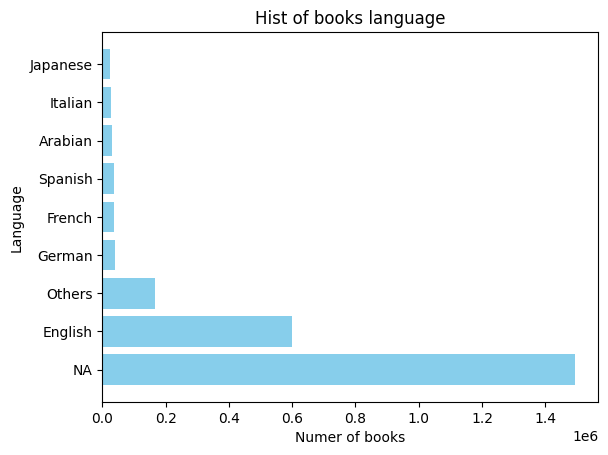

In [91]:
# Plot result
ax = plt.gca()

plt.barh(df['language'], df['language_count'], color = 'skyblue')


plt.title('Hist of books language')
plt.xlabel('Numer of books')
plt.ylabel('Language')

plt.show()

* How many books have more than 250 pages?

In [94]:
# Convert 'pages' column to integers
new_df = books_cleaned[books_cleaned['num_pages'] != ""]
new_df['num_pages'] = new_df['num_pages'].astype(int)

# Filter books with more than 250 pages
books_gt_250_pages = new_df[new_df['num_pages'] > 250]

# Get the count of such books
num_books_gt_250_pages = len(books_gt_250_pages)

print(f'Number of books with more than 250 pages: {num_books_gt_250_pages}')

C:\Users\ricca\AppData\Local\Temp\ipykernel_10600\139754255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['num_pages'] = new_df['num_pages'].astype(int)


Number of books with more than 250 pages: 569314


* Plot the distribution of the fans count for the 50 most prolific authors (the ones who have written more books).

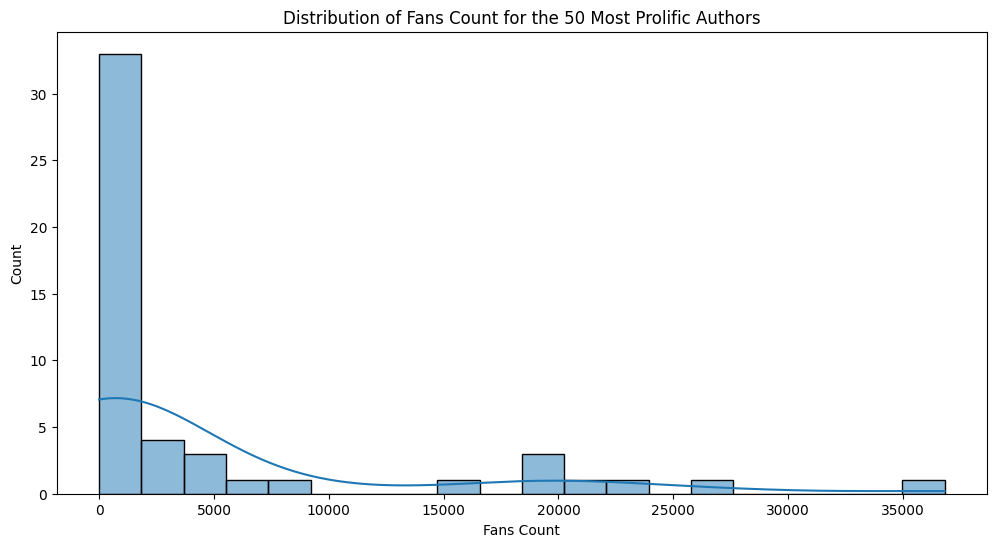

In [95]:
# Task 6: Plot the distribution of the fans count for the 50 most prolific authors
top_authors_by_books = authors.sort_values(by='works_count', ascending=False).head(50)
plt.figure(figsize=(12, 6))
sns.histplot(top_authors_by_books['fans_count'], bins=20, kde=True)
plt.title('Distribution of Fans Count for the 50 Most Prolific Authors')
plt.xlabel('Fans Count')
plt.ylabel('Count')
plt.show()

## [RQ3] Let’s have a historical look at the dataset!

* Write a function that takes as input a year and returns as output the following information:

    - The number of books published that year.

    - The total number of pages written that year.

    - The most prolific month of that year.

    - The longest book written that year.

* Use this function to build your data frame: the primary key will be a year, and the required information will be the attributes within the row. Finally, show the head and the tail of this new data frame considering the first ten years registered and the last ten years.



In [46]:
df_books = books_cleaned[["id", "title", "author_id", "author_name", "num_pages", "publication_date", "original_publication_date"]]

Since we have two different date column then we have to select the one of them after examination of the dataset publication_date column more consistent than original_publication_date column but there are lots of null string ('') values in the both columns. 

For not losing the information, I have decided to get the date from original_publication_date column when publication_date has null string

In [47]:
df_books[(df_books['publication_date']=='') & (df_books['original_publication_date']!='')]

,id,title,author_id,author_name,num_pages,publication_date,original_publication_date
12,15,The Hitchhiker's Guide to Lean: Lessons from t...,951394,Jamie Flinchbaugh,,,2005-12-01
39,49,Bucaneer,17,Luther Butler,,,2000-10-18
81,97,The Birthdays,52,Heidi Pitlor,,,2007-01-01
99,116,The Dune Encyclopedia,1663914,Willis Everett McNelly,,,1984-06
103,120,The Trust: The Private and Powerful Family beh...,985482,Susan E. Tifft,,,1999-12-30
...,...,...,...,...,...,...,...
7027391,25520909,The Hare and the Tortoise,7578490,Mark Anderson,,,2015-05-06
7027409,25520953,Auch Sie können wieder jünger werden,250871,Norman W. Walker,,,2015-05-11
7027412,25520964,"Before That Night (Unfinished Love, #1)",7020583,Violet Duke,,,2016-06-16
7027415,25520980,Renaissances,7493212,H.V. Gavriel,,,2015-05-08


In [48]:
# Replace empty or null strings in column 'publication_date' with values from column 'original_publication_date'
df_books["date"] = np.where(df_books['publication_date'] == '', df_books['original_publication_date'], df_books['publication_date'])

C:\Users\ricca\AppData\Local\Temp\ipykernel_33364\3961617708.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books["date"] = np.where(df_books['publication_date'] == '', df_books['original_publication_date'], df_books['publication_date'])


In [50]:
# Also, num_pages column has 893130 rows empty string
print("num_pages column has:", df_books[df_books['num_pages']==''].shape[0], "empty string")

# Since a book has to be more than 1 page, I have decided to fill empty sting values with the median or mean of the num_pages column
# But first we have to convert the type of the columns to float from string

df_books["num_pages"].replace('', np.nan, inplace=True)

print("The median of the num_pages: ", df_books["num_pages"].median())
print("The mean of the num_pages: ", df_books["num_pages"].mean())

num_pages column has: 893130 empty string
The median of the num_pages:  192.0
The mean of the num_pages:  1604.0680823108953


C:\Users\ricca\AppData\Local\Temp\ipykernel_33364\3367910375.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books["num_pages"].replace('', np.nan, inplace=True)


Mean of the num_pages is too big number, probably the dataset has outliers, that's why we choose the median to fill the empty string

In [51]:
print("Number of empty string count before filling up: ", df_books["num_pages"].isna().sum())

df_books["num_pages"] = df_books["num_pages"].fillna(df_books["num_pages"].median())

Number of empty string count before filling up:  893130


C:\Users\ricca\AppData\Local\Temp\ipykernel_33364\290903980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books["num_pages"] = df_books["num_pages"].fillna(df_books["num_pages"].median())


In [52]:
print("Number of empty string count after filling up with median: ", df_books["num_pages"].isna().sum())

Number of empty string count after filling up with median:  0


In [53]:
# Function to convert valid date strings to datetime, leaving others as NaT

def custom_to_datetime(column, dataset):
    column_formatted = []
    for i in column:
        if len(i) in [4, 7, 10]:
            if len(i) == 4:
                i += "-01-01"

            if len(i) == 7:
                i += "-01"
            try:
                format = "%Y-%m-%d"
                timestamp_formattato = datetime.datetime.strptime(i, format)
                column_formatted.append(timestamp_formattato)
            except ValueError as ve:
                column_formatted.append(pd.NaT)
        else:
            column_formatted.append(pd.NaT)
    dataset['column_formatted'] = column_formatted
    return dataset['column_formatted']

In [54]:
# Apply the custom function to the 'dates' column
df_books['date_time'] = custom_to_datetime(df_books['date'], df_books)

C:\Users\ricca\AppData\Local\Temp\ipykernel_33364\2138385396.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['column_formatted'] = column_formatted
C:\Users\ricca\AppData\Local\Temp\ipykernel_33364\825771272.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books['date_time'] = custom_to_datetime(df_books['date'], df_books)


In [66]:
# Now we can get create month and year column by using date_time column

df_books['month'] = df_books['date_time'].apply(lambda x: x.month if not pd.isna(x) else pd.NaT)
df_books['year'] = df_books['date_time'].apply(lambda x: x.year if not pd.isna(x) else pd.NaT)


C:\Users\ricca\AppData\Local\Temp\ipykernel_33364\146914065.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books['month'] = df_books['date_time'].apply(lambda x: x.month if not pd.isna(x) else pd.NaT)
C:\Users\ricca\AppData\Local\Temp\ipykernel_33364\146914065.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books['year'] = df_books['date_time'].apply(lambda x: x.year if not pd.isna(x) else pd.NaT)


In [67]:
df_books[['month', 'date_time', 'year']]

,month,date_time,year
0,9,2004-09-01 00:00:00,2004
1,11,2003-11-01 00:00:00,2003
2,11,2003-11-01 00:00:00,2003
3,5,2004-05-01 00:00:00,2004
4,9,2002-09-28 00:00:00,2002
...,...,...,...
7027412,6,2016-06-16 00:00:00,2016
7027415,5,2015-05-08 00:00:00,2015
7027419,1,2006-01-01 00:00:00,2006
7027422,1,2015-01-22 00:00:00,2015


In [69]:
# Since 182 rows has no date information, I will drop that rows from the dataset
df_books.isna().sum()
df_books.dropna(axis=0, inplace=True)
df_books.shape[0]

C:\Users\ricca\AppData\Local\Temp\ipykernel_33364\116656058.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books.dropna(axis=0, inplace=True)


2276997

In [70]:
# Converted float month and year column to int
df_books["month"] = df_books["month"].astype(int)
df_books["year"] = df_books["year"].astype(int)

# Since dates after 2023 have not yet occurred, we are removing them from the data as they may be inaccurate data.
df_books_year_filtered = df_books[df_books["year"]<2024]

C:\Users\ricca\AppData\Local\Temp\ipykernel_33364\2241613523.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books["month"] = df_books["month"].astype(int)
C:\Users\ricca\AppData\Local\Temp\ipykernel_33364\2241613523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books["year"] = df_books["year"].astype(int)


In [73]:
df_books.shape
df_books_year_filtered.shape

(2276734, 12)

In [74]:
def get_book_details_by_year(df, year) :

    df = df[df["year"]==year]

    #The number of books published that year
    num_books = len(df)

    #The total number of pages written that year.
    num_pages = df["num_pages"].sum()

    #The most prolific month of that year.
    prolific_month = df.groupby(by=["month"])["id"].count().sort_values(ascending=False).reset_index()["month"].values[0]

    #The longest book written that year.
    longest_book = df["num_pages"].max()


    # Create a new dataframe to return with neccessary attributes
    data = {'Year': [year], 'num_books': [num_books], 'num_pages': [num_pages], 
            'prolific_month': [prolific_month], 'longest_book': [longest_book]}

    df_result = pd.DataFrame(data)

    return df_result


In [75]:
years = range(1950, 2024)
result_df = pd.DataFrame()

for year in years:

    result_df = pd.concat([result_df, get_book_details_by_year(df_books, year)])

In [76]:
result_df.sort_values(by="Year").head()

,Year,num_books,num_pages,prolific_month,longest_book
0,1950,1340,299473.0,1,2550.0
0,1951,1263,288050.0,1,5564.0
0,1952,1329,308467.0,1,1972.0
0,1953,1363,311361.0,1,2922.0
0,1954,1449,324763.0,1,4626.0


In [77]:
result_df.sort_values(by="Year").tail()

,Year,num_books,num_pages,prolific_month,longest_book
0,2019,709,181140.0,1,1113.0
0,2020,480,122191.0,1,3260.0
0,2021,108,28306.0,1,1300.0
0,2022,12,2756.0,1,500.0
0,2023,7,1673.0,1,463.0


* Ask ChatGPT or any other LLM chatbot tool to implement this function and compare your work with the one the bot gave you as an answer. Does the chatbot implementation work? Please test it out and verify the correctness of the implementation, explaining the process you followed to prove it.


In [80]:
def get_book_details_by_year(df, year):
    year_df = df[df["year"] == year]

    if year_df.empty:
        # Handle the case when there are no records for the given year
        return {
            'Year': year,
            'num_books': 0,
            'num_pages': 0,
            'prolific_month': None,
            'longest_book': None
        }

    num_books = len(year_df)
    num_pages = year_df["num_pages"].sum()
    prolific_month = year_df.groupby(by=["month"])["id"].count().sort_values(ascending=False).reset_index()["month"].values[0]
    longest_book = year_df["num_pages"].max()

    return {
        'Year': year,
        'num_books': num_books,
        'num_pages': num_pages,
        'prolific_month': prolific_month,
        'longest_book': longest_book
    }


years = range(2000, 2031)  # Consider the first 31 years as an example

results = [get_book_details_by_year(df_books_year_filtered, year) for year in years]
df_result = pd.DataFrame(results)

# Display the head and tail of the DataFrame
head_and_tail = pd.concat([df_result.head(10), df_result.tail(10)])
head_and_tail

,Year,num_books,num_pages,prolific_month,longest_book
0,2000,44189,1.025312e+07,1.0,7.800000e+03
1,2001,44912,1.057911e+07,1.0,1.397400e+04
2,2002,47513,1.135575e+07,1.0,4.081500e+04
3,2003,52069,1.232873e+07,1.0,1.988800e+04
4,2004,57095,1.332490e+07,1.0,3.113400e+04
5,2005,63689,1.472180e+07,1.0,1.131400e+04
6,2006,89353,2.276263e+07,1.0,6.398700e+04
7,2007,80329,1.875588e+07,1.0,4.134900e+04
8,2008,80574,1.833703e+07,1.0,6.134000e+04
9,2009,88936,2.166996e+09,1.0,2.147484e+09


Chatgpt Answer doesn't work properly. It returns first and last ten years but the data is not correct that has a lot of NaN values.


## [RQ4] Quirks questions about consistency. In most cases, we will not have a consistent dataset, and the one we are dealing with is no exception. So, let's enhance our analysis.

* You should be sure there are no eponymous (different authors who have precisely the same name) in the author's dataset. Is it true?

In [81]:
# check any duplicated author name
print("Is there any duplicated author in the dataset:", authors.name.duplicated().any())

df_author_name_duplicated = authors.name.value_counts().reset_index()
duplicated_author_name_list = list(df_author_name_duplicated[df_author_name_duplicated["count"]>1]["name"].values)

print("Duplicated author name list: ", duplicated_author_name_list)

Is there any duplicated author in the dataset: True
Duplicated author name list:  ['Joseph Fink', 'Boris Zakhoder', 'James Kent', 'Caroline Miller', 'Peter  Marshall', 'William Messner-Loebs', 'Jorge Molina', 'Paul Graham', 'Q. Hayashida', '小野不由美', 'John  Mole', 'James C.L. Carson', 'Mike   Lee', 'Dimitar Dimov', 'Peter      Marshall', 'Yordan Yovkov', 'Cicerón', 'Catherine   Jones', 'Hildegard von Bingen', 'Peter  Davies', 'Robert W. Sullivan IV', 'David Yates', 'Peter    Green', 'Julie  Campbell', 'George  Franklin', 'M.K. Graff', 'Paul      Davies', 'Peter Green', 'محمد نجيب', 'Peter King', 'Jackson Butch Guice', 'Katherine Mercurio Gotthardt', 'Erin  Bedford', 'Martin    Shaw', 'Christopher Phillips', 'Chris Lynch', 'David  Nelson']


* Write a function that, given a list of author_id, outputs a dictionary where each author_id is a key, and the related value is a list 
with the names of all the books the author has written.

In [94]:
authors.rename(columns={'id': 'author_id'}, inplace=True)
df_authors_books = authors.merge(books_cleaned, on='author_id', how='left')

In [95]:
df_authors_books.head(3)

,ratings_count_x,average_rating_x,text_reviews_count_x,work_ids,book_ids,works_count,author_id,name,gender,image_url,...,work_id,average_rating_y,text_reviews_count_y,language,rating_dist,ratings_count_y,publication_date,edition_information,publisher,num_pages
0,2862064,4.19,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...","[386162, 13, 8695, 8694, 6091075, 365, 569429,...",106,4,Douglas Adams,male,https://images.gr-assets.com/authors/159137433...,...,3078186.0,4.22,31417.0,eng,5:753962|4:436665|3:206876|2:60681|1:32955|tot...,1491139.0,2005,Movie Tie-In Edition,Del Rey Books,216
1,2862064,4.19,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...","[386162, 13, 8695, 8694, 6091075, 365, 569429,...",106,4,Douglas Adams,male,https://images.gr-assets.com/authors/159137433...,...,135328.0,4.36,5429.0,eng,5:167705|4:81013|3:32283|2:8665|1:4360|total:2...,294026.0,2005-11-01,,Gramercy Books,815
2,2862064,4.19,62681,"[3078186, 135328, 1877624, 74123, 3078120, 104...","[386162, 13, 8695, 8694, 6091075, 365, 569429,...",106,4,Douglas Adams,male,https://images.gr-assets.com/authors/159137433...,...,69899216.0,4.35,33.0,,5:413|4:234|3:106|2:13|1:4|total:770,770.0,2005-10-25,Dramatization edition; unabridged,BBC Audiobooks,


In [97]:
def get_books_by_author(df, author_ids):
    
    author_books_dict = {}

    for author_id in author_ids:
        books = df[df['author_id'] == author_id]['title'].unique().tolist()
        author_books_dict[author_id] = books

    return author_books_dict

# List of author_ids for which you want to find books
author_ids_to_lookup = [4, 7, 100, 7133040]

result = get_books_by_author(df_authors_books, author_ids_to_lookup)
print(result)

{4: ["The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)", "The Ultimate Hitchhiker's Guide: Five Complete Novels and One Story (Hitchhiker's Guide to the Galaxy, #1-5)", "The Hitchhiker's Guide to the Galaxy: Quandary Phase (Hitchhiker's Guide: Radio Play, #4)", "The Hitchhiker's Guide to the Galaxy: Quintessential Phase (Hitchhiker's Guide: Radio Play, #5)", 'The Long Dark Tea-Time of the Soul (Dirk Gently, #2)', "Dirk Gently's Holistic Detective Agency (Dirk Gently, #1)", 'The Salmon of Doubt (Dirk Gently, #3)', "Mostly Harmless (Hitchhiker's Guide to the Galaxy, #5)", "Life, the Universe and Everything (Hitchhiker's Guide, #3)", 'The Deeper Meaning of Liff', "The Restaurant at the End of the Universe (Hitchhiker's Guide to the Galaxy, #2)", 'Last Chance to See', "So Long, and Thanks for All the Fish (Hitchhiker's Guide to the Galaxy, #4)", "Mostly Brilliant (Hitchhiker's Guide, #1-5)", "Guide to the Hitchhiker's Guide to the Galaxy", "Two Complete Novels: D

* What is the longest book title among the books of the top 20 authors regarding their average rating? Is it the longest book title overall?


In [100]:
# While checking the average author scores to find the top 20 authors, I see that more than 20 authors received full scores, 
# so I add all authors who received 5 points to the best authors list.

df_authors_books.groupby(by='author_id').agg({'average_rating_x': 'first'}).sort_values(by='average_rating_x', ascending=False)

,average_rating_x
author_id,
1954764,5.0
8178264,5.0
19516511,5.0
6873873,5.0
7133040,5.0
...,...
1363742,0.0
7369741,0.0
15879402,0.0


In [115]:
df_authors_books['title_length'] = df_authors_books['title'].apply(lambda x: len(x) if isinstance(x, str) else np.nan)


In [117]:
max_title_len = df_authors_books[df_authors_books["average_rating_x"]==5]["title_length"].max()
print("Maximum title length is: ", max_title_len)

Maximum title length is:  255.0


In [118]:
# There are 713 rows has a maximum title length (255)
df_authors_books[df_authors_books["title_length"] == max_title_len][["author_id", "name", "title", "title_length"]]

,author_id,name,title,title_length
13801,632,Lon Milo DuQuette,The Grand and Noble Order of Button Busters: A...,255.0
19888,947,William Shakespeare,Shakespearean extracts from Edward Pudsey's bo...,255.0
26712,1438,Walt Whitman,"The gathering of the forces; editorials, essay...",255.0
27996,1480,John Adams,Biographical Sketches of Distinguished America...,255.0
30426,1673,Thomas Jefferson,"A Manual of Parliamentary Practice, Composed O...",255.0
...,...,...,...,...
2535269,15878806,Henry Moore,Instructions for Preparing Abstracts of Titles...,255.0
2535469,15885133,Robert Pocock,"Pocock's everlasting songster, containing a se...",255.0
2536148,15912139,Samuel Clarke,"A Collection of the Promises of Scripture, Und...",255.0
2536940,15948238,Charles Owen,"Plain reasons, I. For dissenting from the comm...",255.0


* What is the shortest overall book title in the dataset? If you find something strange, provide a comment on what happened and an alternative answer.


In [119]:
# There aren't rows without any name
print(df_authors_books[df_authors_books["title_length"]==0].shape)

df_authors_books[df_authors_books["title_length"]==0].head(3)

(0, 31)


,ratings_count_x,average_rating_x,text_reviews_count_x,work_ids,book_ids,works_count,author_id,name,gender,image_url,...,average_rating_y,text_reviews_count_y,language,rating_dist,ratings_count_y,publication_date,edition_information,publisher,num_pages,title_length


In [127]:
df_authors_books[df_authors_books["title_length"]==1]
# there are 236 titles with length equal to 1

,ratings_count_x,average_rating_x,text_reviews_count_x,work_ids,book_ids,works_count,author_id,name,gender,image_url,...,average_rating_y,text_reviews_count_y,language,rating_dist,ratings_count_y,publication_date,edition_information,publisher,num_pages,title_length
22769,47012,3.81,1135,"[1283844, 366428, 382424, 58136682, 47615, 968...","[31818, 376579, 130940, 36436103, 48672, 10047...",218,1203,Andy Warhol,male,https://images.gr-assets.com/authors/120656521...,...,3.39,22.0,,5:61|4:48|3:70|2:27|1:26|total:232,232.0,1998-02-17,,Grove Press,384,1.0
27546,15836,3.71,1133,"[537899, 1810799, 1192753, 100524, 1817057, 56...","[550655, 919995, 104260, 104262, 919987, 15247...",903,1464,George Sand,female,https://images.gr-assets.com/authors/134111243...,...,3.75,0.0,,5:1|4:1|3:2|2:0|1:0|total:4,4.0,,,,,1.0
48869,68829,3.70,6923,"[502278, 6512514, 14916864, 1874015, 64658630,...","[514313, 6326920, 10021420, 86161, 41433284, 9...",34,2850,Ben Mezrich,male,https://images.gr-assets.com/authors/140544550...,...,3.59,39.0,eng,5:66|4:103|3:84|2:36|1:11|total:300,300.0,2015-01-01,,FG Press,160,1.0
68276,3392332,4.12,97735,"[1015554, 2765786, 1249788, 2379261, 105046, 8...","[39988, 6310, 6319, 6689, 6327, 31456, 6693, 6...",825,4273,Roald Dahl,male,https://images.gr-assets.com/authors/131155490...,...,4.25,1.0,,5:3|4:0|3:0|2:1|1:0|total:4,4.0,2005-05-30,,강,353,1.0
74646,43540,4.26,1712,"[273861, 23929637, 18280, 273864, 6229228, 273...","[282308, 17295645, 16602, 282311, 6053428, 282...",165,4743,Yoshitaka Amano,male,https://images.gr-assets.com/authors/124492114...,...,5.00,0.0,ger,5:1|4:0|3:0|2:0|1:0|total:1,1.0,,,,,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2498568,163,3.96,7,"[2426727, 21505358, 43597609, 15313686, 407875...","[17900446, 15786351, 23997091, 10409565, 21469...",36,14381327,Dumitru Radu Popescu,male,https://s.gr-assets.com/assets/nophoto/user/m_...,...,4.33,0.0,rum,5:6|4:4|3:2|2:0|1:0|total:12,12.0,2000,1,Gramar,316,1.0
2502247,2,5.00,0,"[64629537, 52890761, 56156380, 24270915, 59343...","[41410287, 32262726, 34901031, 17418023, 37709...",22,14539438,Philippe Dautzenberg,,https://s.gr-assets.com/assets/nophoto/user/u_...,...,0.00,0.0,,5:0|4:0|3:0|2:0|1:0|total:0,0.0,,,,,1.0
2525292,8,3.62,2,"[16920761, 47026229, 66214585, 19975563, 69519...","[11958502, 26976387, 42502486, 14333723, 44849...",33,15379169,Thomas Balch,,https://s.gr-assets.com/assets/nophoto/user/u_...,...,0.00,0.0,,5:0|4:0|3:0|2:0|1:0|total:0,0.0,,,,,1.0
2525875,0,0.00,0,"[68604288, 64782294, 86346988, 48600290, 17282...","[44111406, 41509071, 30767954, 28462303, 12305...",8,15405966,Stanisław II August,female,https://images.gr-assets.com/authors/160040463...,...,0.00,0.0,,5:0|4:0|3:0|2:0|1:0|total:0,0.0,,,,,1.0


In [120]:
# There are 920 rows without a name
print(df_authors_books[df_authors_books["title_length"]<3].shape)
df_authors_books[df_authors_books["title_length"]<3].head(3)

(920, 31)


,ratings_count_x,average_rating_x,text_reviews_count_x,work_ids,book_ids,works_count,author_id,name,gender,image_url,...,average_rating_y,text_reviews_count_y,language,rating_dist,ratings_count_y,publication_date,edition_information,publisher,num_pages,title_length
7563,2481167,4.12,62472,"[153313, 1477756, 866393, 6151926, 2999000, 23...","[5471, 2794, 415, 5933841, 5809, 17208457, 413...",46,235,Thomas Pynchon,male,https://images.gr-assets.com/authors/146536115...,...,3.96,1059.0,eng,5:6852|4:7307|3:3737|2:1100|1:536|total:19532,19532.0,2005-07-05,,Harper Perennial Modern Classics,547,2.0
9255,205867,3.75,13441,"[929649, 2226163, 6518120, 6574787, 46813511, ...","[599, 597, 24475, 6386555, 27068734, 24476, 21...",117,375,Chuck Klosterman,male,https://images.gr-assets.com/authors/133606020...,...,3.00,0.0,,5:0|4:1|3:0|2:1|1:0|total:2,2.0,,,,,2.0
22769,47012,3.81,1135,"[1283844, 366428, 382424, 58136682, 47615, 968...","[31818, 376579, 130940, 36436103, 48672, 10047...",218,1203,Andy Warhol,male,https://images.gr-assets.com/authors/120656521...,...,3.39,22.0,,5:61|4:48|3:70|2:27|1:26|total:232,232.0,1998-02-17,,Grove Press,384,1.0


## [RQ5] We can consider the authors with the most fans to be influential. Let’s have a deeper look.



* Plot the top 10 most influential authors regarding their fan count and number of books. Who is the most influential author?


We start by importing the useful columns of the 2 datasets to work properly on it and to store less memory.

In [98]:
df_5_b_2 = books_cleaned[["id", "title", "author_id", "author_name", "series_name", "series_id", "series_position", "format", "original_publication_date", "work_id", "average_rating", "text_reviews_count"]]

Plotting the 10 most influential authors regarding their fan_count. We use the dataset "authors".

In [99]:
df_sorted_fc = authors.sort_values(by=authors.columns[11], ascending = False)

fc_columns = df_sorted_fc.iloc[:, [6, 7, 11]]


most_influent_authors = dict()
count = 0

for i, j in zip(fc_columns["name"], fc_columns["id"]):
    most_influent_authors[i] = j
    count += 1
    if count == 10:
        break

most_influent_authors
fc_columns.head(10) # to print only the first 10.


,id,name,fans_count
1017,3389,Stephen King,766035
169374,4039811,Veronica Roth,455358
6397,23470,Bill Gates,446876
205870,5430144,Colleen Hoover,356633
4537,15872,Rick Riordan,339346
1161,3780,James Patterson,317040
100166,1406384,John Green,282537
3818,12855,Neil deGrasse Tyson,277850
27110,150038,Cassandra Clare,238560
32358,194416,Mindy Kaling,234647


Let's work on cleaning up the dataset with respect to the publication date, as it contains various date formats that need to be standardized for a better analysis.




In [101]:
# Work on the data_frame to fix the variable publication_date and create a new column formatted as "%Y-%m-%d"

opd_column = df_5_b_2["original_publication_date"]
opd_column_formatted = []

for i in opd_column:
    if len(i) in [4, 7, 10]:
        if len(i) == 4:
            i += "-01-01"

        if len(i) == 7:
            i += "-01"
        try:
            format = "%Y-%m-%d"
            timestamp_formattato = datetime.datetime.strptime(i, format)
            opd_column_formatted.append(timestamp_formattato)
        except ValueError as ve:
            opd_column_formatted.append(pd.NaT)
    else:
        opd_column_formatted.append(pd.NaT)

df_5_b_2['opd_column_formatted'] = opd_column_formatted

C:\Users\ricca\AppData\Local\Temp\ipykernel_10600\542818827.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5_b_2['opd_column_formatted'] = opd_column_formatted


Let's also clean 'original_publication_date' column deleting outliers.

We have chosen to remove outliers using the 1st percentile as the lower limit and today's date as the upper limit. However, there are different ways to implement this procedure.

In [102]:
df_5_b_2['opd_column_formatted'] = pd.to_datetime(df_5_b_2['opd_column_formatted'], errors='coerce')

Q_01 = df_5_b_2['opd_column_formatted'].quantile(0.01)

# Calculate the limits for outliers
lower_limit = pd.to_datetime(Q_01)
upper_limit = pd.to_datetime("2023-11-02 00:00:00")

# Filter the DataFrame to remove outliers
df_5_b_2 = df_5_b_2[(df_5_b_2['opd_column_formatted'] >= lower_limit) & (df_5_b_2['opd_column_formatted'] <= upper_limit)]

C:\Users\ricca\AppData\Local\Temp\ipykernel_10600\1796103921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_5_b_2['opd_column_formatted'] = pd.to_datetime(df_5_b_2['opd_column_formatted'], errors='coerce')


In [103]:
# Count unique works_id for every author_id
count_work_id = df_5_b_2.groupby('author_id')['work_id'].nunique()

# Get the result as dataframe
result_df = count_work_id.reset_index()

# Rename columns
result_df.columns = ['author_id', 'num_works']

result_df = result_df.merge(df_5_b_2[['author_id', 'author_name']].drop_duplicates(), on='author_id', how='left')

result_df_books = result_df.sort_values(by='num_works', ascending=False)

result_df_books.head(10)

,author_id,num_works,author_name
156182,5823409,88499,Jesse Russell
2590,8777,26988,Philip M. Parker
123848,4340042,16715,Books LLC
116335,3510823,4693,Walt Disney Company
24048,136264,4276,Organisation for Economic Co-operation and Dev...
142332,5167894,3600,Hephaestus Books
121175,4156059,3364,Livres Groupe
60,119,2968,McDougal Littell
41454,323872,2800,McGraw-Hill Education
202954,7437759,2719,Institute of Electrical and Electronics Engineers


This table above represents the first 10 "authors", sorted by their publications. As expected they are pretty much all companies or classes such as 'Various' or 'UNKNOWN'. 

But we can visualize the table without these elements with the code below.

In [104]:
x = ['NOT A BOOK', 'Unknown', 'Various', 'Anonymous']
result_df_books = result_df_books.loc[~result_df_books['author_name'].isin(x)]
result_df_books.head(10)

,author_id,num_works,author_name
156182,5823409,88499,Jesse Russell
2590,8777,26988,Philip M. Parker
123848,4340042,16715,Books LLC
116335,3510823,4693,Walt Disney Company
24048,136264,4276,Organisation for Economic Co-operation and Dev...
142332,5167894,3600,Hephaestus Books
121175,4156059,3364,Livres Groupe
60,119,2968,McDougal Littell
41454,323872,2800,McGraw-Hill Education
202954,7437759,2719,Institute of Electrical and Electronics Engineers


In [105]:
result_df_5 = []
result_df = result_df[result_df['author_id'].isin(most_influent_authors.values())]
result_df

for key, value in most_influent_authors.items():
    result_df_5.append([key, value, result_df[result_df['author_id'] == value]['num_works'].iloc[0], authors[authors['id'] == value]['fans_count'].iloc[0]])

result_df_5 = pd.DataFrame(result_df_5)
result_df_5.columns = ['author_name', 'author_id', 'number_of_books', 'fans_count']
result_df_5

,author_name,author_id,number_of_books,fans_count
0,Stephen King,3389,375,766035
1,Veronica Roth,4039811,19,455358
2,Bill Gates,23470,2,446876
3,Colleen Hoover,5430144,18,356633
4,Rick Riordan,15872,66,339346
5,James Patterson,3780,247,317040
6,John Green,1406384,15,282537
7,Neil deGrasse Tyson,12855,10,277850
8,Cassandra Clare,150038,73,238560
9,Mindy Kaling,194416,3,234647


The most influent author is Stephen King with 776035 fans and 375 books published. 

It's not surprising that he has so many fans, considering he's the author with the most books published among the top 10 influential authors.

* Have they published any series of books? If any, extract the longest series name among these authors.



In [106]:
list_series = []

for i in most_influent_authors:
    selected_row = df_5_b_2.loc[df_5_b_2['author_id'] == most_influent_authors[i]]
    variable_value = selected_row['series_name'].values
    variable_value = list(set(variable_value))
    variable_value.remove('')
        
    if variable_value == []:
        print(f"The author {i} hasn't written any series.")
        print()
    else:
        count = 1
        print(f"The author {i} has written the next series: ")
        for j in variable_value:
            print(f"{count}. {j}")
            count += 1
            list_series.append(j)
        print()

The author Stephen King has written the next series: 
1. It (3 volumes)
2. Nightmares & Dreamscapes
3. It (2 volumes)
4. Under the Dome Split-Volume
5. The Shining Split-Volume
6. Bill Hodges Trilogy
7. The Shining
8. The Dark Tower: Graphic Novels
9. The Stand (3 volumes)
10. Different Seasons
11. Insomnia Split-Volume
12. Danse macabre
13. The Green Mile
14. Bazaar
15. The Dark Tower
16. Dreamcatcher Split-Volume
17. Everything's Eventual [Japanese]
18. The Stand (split volumes)
19. Les Tommyknockers
20. The Best American Short Stories
21. 暗黒の塔
22. アンダー・ザ・ドーム
23. ドリームキャッチャー
24. The Secretary of Dreams
25. The Stand: Graphic Novels
26. The Talisman
27. Skeleton Crew
28. Pesadillas y alucinaciones
29. Duma Key Split-Volume

The author Veronica Roth has written the next series: 
1. Divergent
2. Divergent Japanese Split-Volume Edition

The author Bill  Gates hasn't written any series.

The author Colleen Hoover has written the next series: 
1. Never Never
2. Hopeless
3. Slammed
4. Maybe


Bill Gates and Mindy Kaling have not authored any series. The other authors have written numerous series, many of which have been translated into multiple languages and published under different titles in various locations. For instance, Stephen King, an American author, is highly popular in Japan, and as a result, some of his series are also available there, as indicated by the previous code's output.

Now, let's extract the longest series name among those found earlier.

In [ ]:
longest_string = ""

for string in list_series:
    if len(string) > len(longest_string):
        longest_string = string

sorted_list = sorted(list_series, key=len)
print(longest_string)

In [ ]:
###### SERIES_POSITION CHECKKK #########

The longest series name is: Percy Jackson and the Olympians: The Graphic Novels

* How many of these authors have been published in different formats? Provide a meaningful chart on the distribution of the formats and comment on it.


Before starting let's create a new database without the books that don't have a format starting from the uncleaned database "books"

In [ ]:
books_format = books[books['format'] != ""]

In [ ]:
# To answer this question we use the original database and not "df_5_b_2" because we need to evaluate all kinds of formats published by an author,
# even if there are more formats for the same opera.

for i in most_influent_authors:
    sel_row = books_format.loc[books_format['author_id'] == most_influent_authors[i]]
    value_var = sel_row['format'].values
    app = Counter(value_var)
    count = 0
    new_dict = {}
    
    total = sum(app.values())
    
    for key in app:
        if app[key]/total < 0.02:
            count += np.round(app[key]/total, 3)
        else:
            new_dict[key] = np.round(app[key]/total, 3)
    
    if count != 0:
        new_dict['Others'] = count

    # print(f"{i} ha: {new_dict}")

    cat = new_dict.keys()  
    val = new_dict.values()   
    plt.bar(cat, val)

    # add labels
    plt.xlabel("Format")
    plt.ylabel("Percentage")
    plt.title(f"{i}'s format works histogram")
    plt.xticks(rotation = 90)
    
    # show the plot
    plt.show()

These graphs display the distributions of book formats for each of the most influential authors. To streamline the presentation, we have categorized all formats that represent less than 2% into a class labeled 'Others' to prevent an excessive number of different formats.


We can observe that the most prevalent formats are Paperback and Hardcover, followed by eBooks and Audiobooks. This highlights how paper has not yet been completely overtaken by digital formats and how people still appreciate purchasing books as they used to.

We can also notice that more recent authors tend to use digital publications, unlike older authors. Furthermore authors that has more series use more different formats.

* Provide information about the general response from readers (number of fans, average rating, number of reviews, etc.), divide the authors by gender, and comment about anything eventually related to “structural bias”. You can even ask ChatGPT or any other LLM chatbot tool: try to formulate a prompt that provides helpful information about it. Put that information in your notebook and provide comments on what you found.

In [ ]:
df_authors_10 = authors[authors['id'].isin(most_influent_authors.values())]

df_authors_10 = df_authors_10[df_authors_10['gender'] != ""]

## df_authors_10 = authors[authors['gender'].isin(['male', 'female'])]

grouped = df_authors_10.groupby('gender')

# Calculate mean, median, and standard deviation for each group
summary_stats = grouped.agg({
    'fans_count': ['mean', 'median', 'std'],
    'average_rating': ['mean', 'median', 'std'],
    'text_reviews_count': ['mean', 'median', 'std']
})

# Rename the columns for clarity
summary_stats.columns = ['fans_mean', 'fans_median', 'fans_sd',
                         'rating_mean', 'rating_median', 'rating_sd',
                         'reviews_mean', 'reviews_median', 'reviews_sd']

# Reset the index to make 'gender' a regular column
summary_stats.reset_index(inplace=True)

# Display the summary statistics
summary_stats
# df_authors_10

## [RQ6] For this question, consider the top 10 authors concerning the number of fans again.

* Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?


To answer this question, we need to clean the 'series_position' column first. This is because some series have a sort of spin-off that contains more than one volume, and there are also some kinds of books that are not part of the main saga.

In [ ]:
ids = list(most_influent_authors.values())

# Filter the original dataframe based on the ID's 
df_initial = df_5_b_2[df_5_b_2['author_id'].isin(ids)] 

Only considering books that are part of a series.

In [ ]:
df_series = df_initial.dropna(subset=['opd_column_formatted', 'series_id', 'series_position']) # dropping all the books that are not part of a series
df_series = df_series[df_series['series_id'] != ""]
df_series = df_series[df_series['series_position'] != ""]
len(df_series) # 368 books not belonging to a series

In [ ]:
df_series = df_series.sort_values(by=['series_id', 'series_position'])

df_series['time_gap'] = df_series.groupby('series_id')['opd_column_formatted'].diff()

In [ ]:
df_series['time_gap'] = df_series['time_gap'].astype(str) 
df_series['time_gap'] = df_series['time_gap'].replace('0:00:00', np.nan) # we are not considering time gaps equal to 0
df_series['time_gap'] = pd.to_timedelta(df_series['time_gap'])

media_timegap_series = df_series['time_gap'].mean()
print(f"Time gap between 2 consecutive publications of books belonging to a series is: {media_timegap_series.days} days")

We found out the average time gap between two subsequent publications for a series of books is equal to **340 days**, equal to 1 year more or less.

Before delving into the solution of the other average time between two books not belonging to a series, it's important to an assumption.

We expect that there will be a shorter time gap between the consecutive publications of books within a series. This expectation is based on the likelihood that an author often works on multiple books within the same series simultaneously or begins working on the next one almost immediately after releasing the most recent installment. This is in contrast to two books that are not part of the same series, where we might expect longer intervals between their publications.

So let's create a new subset to analyze the time gap between two books not belonging to a series.


In [ ]:
df_not_series = df_initial.drop(columns = ['series_position', 'original_publication_date']) # we work again on the original dataset because we need also the NA's series_id
df_not_series = df_not_series[df_not_series['series_id'] == ""]
df_not_series = df_not_series.sort_values(by=['author_id', 'opd_column_formatted'])

print(len(df_not_series)) # 447 books within a series

In [ ]:
time_gap_books = df_not_series.groupby('author_id')['opd_column_formatted'].diff()
df_not_series['time_gap_books'] = time_gap_books
df_not_series['time_gap_books'] = df_not_series['time_gap_books'].replace(datetime.timedelta(0), pd.NaT) # we are not considering timedelta(0)
df_not_series['time_gap_books'] = df_not_series['time_gap_books'].replace(np.nan, pd.NaT)


In [ ]:
# Let's finally compute the mean

a = datetime.timedelta(0)
conta = 0

for i in df_not_series['time_gap_books']:
    if str(type(i)) != "<class 'pandas._libs.tslibs.nattype.NaTType'>":
        a += i
        conta += 1

print(f"Time gap between 2 consecutive publications of books not belonging to a series is {(a/conta).days} days")

Unexpected, the time gap between the release of two consecutive books, which are not part of a series, is **204 days**. Notably, this 204-day gap is approximately two-thirds of the time gap calculated for some other context.

############# COMMENTSSS #######

* For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?


In [ ]:
# Let's start by creating a new column of the subset with the year of the original publication of every book

df_6 = df_5_b_2[["author_id", "original_publication_date", "work_id"]]

df_6 = df_6[df_6['author_id'].isin(ids)]

opd_column = df_6["original_publication_date"]
year_of_publication = []

for i in opd_column:
    if len(i) in [4, 7, 10]:
        if len(i) == 4:
            i += "-01-01"

        if len(i) == 7:
            i += "-01"
        
        format = "%Y-%m-%d"
        timestamp_format = datetime.datetime.strptime(i, format)
        year_of_publication.append(timestamp_format.year)
    else:
        year_of_publication.append(pd.NaT)

df_6['opd_column_formatted'] = year_of_publication
df_6 = df_6.dropna(subset=['opd_column_formatted'])
df_6

######## COMMENTS #########

In [ ]:
for i in most_influent_authors:
    row = df_6.loc[df_6['author_id'] == most_influent_authors[i]]
    vv = row['opd_column_formatted'].values
    app = Counter(vv)
    count = 0
    
    # print(f"{i} ha: {app}")

    cat = sorted(app.keys())
    val = app.values()
    cumulative_hist = []
    i_esimo = 0
    
    for year in cat:
        i_esimo += app[year]
        cumulative_hist.append(i_esimo)
            
        
    # print(cat, cumulative_hist)
    # plt.bar(cat, cumulative_hist)
    
    for j in range(len(cumulative_hist) - 1):
        plt.plot([cat[j], cat[j + 1]], [cumulative_hist[j], cumulative_hist[j]], color='b', linestyle='-')

    plt.hlines(cumulative_hist[-1], cat[-1], cat[-1] + 0.5, colors='b', linestyles='-')

    # add labels
    plt.xlabel("Years")
    plt.ylabel("Books published")
    plt.title(f"{i}'s cumulative distribution of works")
    plt.xticks(rotation = 90)
    for j in range(1, len(cumulative_hist)):
        plt.vlines(cat[j], cumulative_hist[j-1], cumulative_hist[j], colors='b', linestyles='-')

    # show the plot
    plt.show()
    

We have chosen to represent the cumulative distribution of published books using the ECDF (Empirical Cumulative Distribution Function) without normalization. This approach allows us to visualize the publication distribution up to a specific year more effectively.


It seems that all these authors are roughly contemporary with each other. Some, like Stephen King, have had long careers spanning from 1960 to the present day, while others, such as Bill Gates, have only published a few books. Their book production appears to be more consistent during the first two decades of the 2000s.

## BONUS POINTS
***1.***
Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload authors.json dataset, and filter authors with at least 100 reviews. 

Do the same using Pandas and compare performance in terms of milliseconds.

In [ ]:
start_time = time.time()

file_path = "./lighter_authors.json"

# Read the JSON file into a Dask DataFrame
df_9 = dd.read_json(file_path)

# Filter authors with at least 100 reviews
result = df_9[df_9['text_reviews_count'] >= 100]
end_time = time.time()

# Print the result and the time taken in milliseconds
result
print(f"Time taken using Dask: {(end_time - start_time) * 1000} ms")


In [ ]:
start_time = time.time()

file_path = "./lighter_authors.json"

# Read the JSON file into a Dask DataFrame
df_9 = pd.read_json(file_path, lines = True)

# Filter authors with at least 100 reviews
result = df_9[df_9['text_reviews_count'] >= 100]
end_time = time.time()

# Print the result and the time taken in milliseconds
result
print(f"Time taken using Pandas: {(end_time - start_time) * 1000} ms")

Uploading file "lighter_authors" and filtering authors with more than 100 reviews lasts about one half using Pandas instead of Dask, **32262 ms** against **13582 ms**.
So for this kind of operations is more convenient using the first library.

***2*** Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload books.json, and join them with authors.json based on author_id. How many books don’t have a match for the author?

In [ ]:
##### DO NOT RUN ####
file_path_1 = "./lighter_authors.json"
file_path_2 = "./lighter_books.json"

# Read the "books.json" and "authors.json" datasets into Dask DataFrames
books_df = dd.read_json(file_path_2)
authors_df = dd.read_json(file_path_1)

# Perform the inner join on 'author_id'
joined_df = dd.merge(books_df, authors_df, on='author_id', how='inner')

# Find the number of books without a matching author
books_without_author = len(books_df) - len(joined_df)
print(f"Number of books without a matching author: {books_without_author.compute()}")


In [ ]:
light_authors = ".\lighter_authors.json"
ch_size = 100
dfs = []

# to import only some columns
with open(light_authors, "r") as file:
        for ch in pd.read_json(file, lines = True, chunksize = ch_size):
                ch = ch[["name", "works_count","ratings_count","average_rating",
"text_reviews_count", "work_ids", "book_ids","id",
"gender",
"about","fans_count"]]
        dfs.append(ch)

la = pd.concat(dfs, ignore_index = True)

## [RQ7]  Estimating probabilities is a core skill for a data scientist: show us your best!

* Estimate the probability that a book has over 30% of the ratings above 4.

In [ ]:
lighter_books = ".\lighter_books.json"
ch_size = 100
dfbs = []

# we import the dataset
with open(lighter_books, "r") as fileb:
    rows_read = 0
    for chb in pd.read_json(fileb, lines = True, chunksize = ch_size):
        chb = chb[["id", "title", "author_name","author_id", "work_id",
"language","average_rating","rating_dist","ratings_count","text_reviews_count","publication_date",
"original_publication_date", "format","edition_information","publisher","num_pages",
"series_id","series_name","series_position"]]
        dfbs.append(chb)
#       Update the count of rows read
        rows_read += len(chb)
        
        # Check if we have read 10,000 rows, and if so, break the loop
        if rows_read >= 100000:
            break
            
#final data with our books
lb = pd.concat(dfbs, ignore_index = True)

In [ ]:
#we chose the data we want to study, in this case lighter_books
dr = books[['rating_dist','ratings_count']]

#we change rating_dist to str to be able to separate the values of each rating
dr['rating_dist'] = dr['rating_dist'].astype(str)


#we define a function to separate the ratings we want
def parse_rating_dist(rating_dist):
    match = re.search(r'5:(\d+)', rating_dist)
    if match:
        ratings_5 = int(match.group(1))
    else:
        ratings_5 = 0

    match = re.search(r'4:(\d+)', rating_dist)
    if match:
        ratings_4 = int(match.group(1))
    else:
        ratings_4 = 0  

    return ratings_4, ratings_5

# Apply the parsing function
dr['ratings_4'], dr['ratings_5'] = zip(*dr['rating_dist'].map(parse_rating_dist))



# Calculate the probability
dr['proportion_above_4'] = (dr['ratings_4'] + dr['ratings_5']) / dr['ratings_count']


# Estimate the probability
probability_above_30_percent = (dr['proportion_above_4'] > 0.30).mean()

print(probability_above_30_percent)

print(f"Estimated probability that a book has over 30% of ratings above 4: {probability_above_30_percent:.2%}")
pr = 0
for i in range(0,len(dr)):
    if dr['proportion_above_4'] [i] > 0.30:
        pr += 1
print('The probability to have over 30% of above 4 is',pr/(len(dr))*100,'%')


* Estimate the probability that an author publishes a new book within two years from its last work.

In [ ]:

# we get the columsn we'll need
dt = lb[['title','author_id','publication_date','original_publication_date']]

# we change the  datetime to be able touse it more easily
dt['original_publication_date'] = pd.to_datetime(dt['original_publication_date'], errors='coerce')

dt.sort_values(by=['author_id', 'original_publication_date'], ascending=True, inplace=True)
print(dt)
# Calculate time gaps
dt['time_gap'] = dt.groupby('author_id')['original_publication_date'].diff()
print(dt)

# Handle invalid (out-of-bounds) dates by replacing them with the previous work's publication date
dt['original_publication_date'] = dt.groupby('author_id')['original_publication_date'].fillna(method='ffill')
print(dt)

# Filter the data
filtered_data = dt.dropna(subset=['original_publication_date', 'time_gap'])
print(filtered_data)
filtered_data = filtered_data[filtered_data.groupby('author_id')['author_id'].transform('size') > 1]
print(filtered_data)
# Calculate the probability
probability_within_two_years = dt.groupby('author_id')['time_gap'].apply(lambda x: (x <= timedelta(days=730)).any()).mean()

print(f"Estimated probability that an author publishes a new book within two years from their last work: {probability_within_two_years:.2%}")


* In the file list.json, you will find a peculiar list named "The Worst Books of All Time." Estimate the probability of a book being included in this list, knowing it has more than 700 pages.

In [ ]:
file_path = "list.json"
ch_size = 100
dfls = []

# to import only some columns
with open(file_pathl, "r") as filel:
    rows_read = 0
    for chl in pd.read_json(filel, lines = True, chunksize = ch_size):
        chl = chl[["id",
"title",
"description","description_html","num_pages",
"num_books",
"num_voters",
"created_date",
"tags",
"num_likes",
"created_by",
"num_comments",
"books"]]
        dfls.append(chl)
#          Update the count of rows read
        rows_read += len(chl)
        
        # Check if we have read 10,000 rows, and if so, break the loop
        if rows_read >= 100000:
            break

dfl = pd.concat(dfls, ignore_index = True)

In [ ]:
import pandas as pd

lb['num_pages'] = pd.to_numeric(lb['num_pages'], errors='coerce')  # Convert to integers and handle errors
books_with_more_than_700_pages = lb[lb['num_pages'] > 700]

# Step 2: Identify books in "The Worst Books of All Time" list
# Assuming 'list' contains information about the list, extract the relevant book titles from it
rs = dfl[dfl['title'] == "The Worst Books of All Time"]

# Extract the titles of the books in the list

# Create a new Series containing book dictionaries
book_series = rs['books'].apply(lambda x: [item['title'] for item in x])

# Create a flattened list of titles
book_titles = [title for titles in book_series for title in titles]

# Step 2: Identify books in the extracted list
books_in_extracted_list = books_with_more_than_700_pages[books_with_more_than_700_pages['title'].isin(book_titles)]

# Step 3: Calculate the probability
total_books = len(books_with_more_than_700_pages)
books_in_list_count = len(books_in_extracted_list)

probability_in_list_given_700_pages = books_in_list_count / total_books

print(probability_in_list_given_700_pages)

In [ ]:
import pandas as pd

# Assuming 'lb' is a DataFrame containing book information
# 'list' is a DataFrame containing list information

# Step 1: Filter books with more than 700 pages from 'lb'
# Convert 'num_pages' to integers and then filter
lb['num_pages'] = pd.to_numeric(lb['num_pages'], errors='coerce')  # Convert to integers and handle errors
books_with_more_than_700_pages = lb[lb['num_pages'] > 700]

# Step 2: Identify books in "The Worst Books of All Time" list
# Assuming 'list' contains information about the list, extract the relevant book titles from it
worst_books_list = dfl[dfl['title'] == "The Worst Books of All Time"]

# Step 3: Calculate the probability
total_books = len(books_with_more_than_700_pages)
books_in_worst_list_count = len(worst_books_list)

probability_on_worst_list = books_in_worst_list_count / total_books

print(f"Estimated probability of a book being on 'The Worst Books of All Time' list, given it has more than 700 pages: {probability_on_worst_list:.2%}")


In [ ]:
# Calculate P(X), the probability of being in the list
total_books = len(books_with_more_than_700_pages)  # Number of books with more than 700 pages
books_in_worst_list_count = len(books_in_extracted_list)  # Number of books in the list

P_X = books_in_worst_list_count / total_books

# Calculate P(X|Y), the probability of being in the list given more than 700 pages
total_books_with_more_than_700_pages = len(books_with_more_than_700_pages)  # Total books with more than 700 pages
books_in_extracted_list_count = len(books_in_extracted_list)  # Number of books in the list with more than 700 pages
P_X_given_Y = books_in_extracted_list_count / total_books_with_more_than_700_pages

# Compare the probabilities
if P_X_given_Y == P_X:
    print("The events X and Y are independent.")
else:
    print("The events X and Y are dependent.")


In [ ]:
file_pathb = "lighter_books.json"
ch_size = 100
dfbs = []

# to import only some columns
with open(file_pathb, "r") as fileb:
    rows_read = 0
    for chb in pd.read_json(fileb, lines = True, chunksize = ch_size):
        chb = chb[["id", "title", "author_name","author_id", "work_id",
"language","average_rating","rating_dist","ratings_count","text_reviews_count","publication_date",
"original_publication_date", "format","edition_information","publisher","num_pages",
"series_id","series_name","series_position"]]
        dfbs.append(chb)
         # Update the count of rows read
        rows_read += len(chb)
        
        # Check if we have read 10,000 rows, and if so, break the loop
        if rows_read >= 100000:
            break

lb = pd.concat(dfbs, ignore_index = True)

In [ ]:
import pandas as pd
import scipy.stats as stats


# Load your dataset (replace 'your_dataset.csv' with your actual file)
dav = lb[['average_rating','num_pages']]

# Data preparation and cleaning
dav['average_rating'] = dav['average_rating'].astype(float)

# Remove rows with missing or empty 'num_pages' values
dav = dav[dav['num_pages'].str.strip() != '']
dav['num_pages'] = dav['num_pages'].astype(float)

# Define the book length groups
# You can customize the cutoffs for short, medium, and long books based on your data.
short = dav[dav['num_pages'] <= 150]
med = dav[(dav['num_pages'] > 150) & (dav['num_pages'] <= 700)]
long = dav[dav['num_pages'] > 700]

# Calculate summary statistics for average ratings
mean_short = short['average_rating'].mean()
mean_med = med['average_rating'].mean()
mean_long = long['average_rating'].mean()

# Perform hypothesis testing (e.g., ANOVA) to determine if there are significant differences
f_statistic, p_value = stats.f_oneway(short['average_rating'], med['average_rating'], long['average_rating'])

print(f"Mean rating for short books: {mean_short:.2f}")
print(f"Mean rating for medium books: {mean_med:.2f}")
print(f"Mean rating for long books: {mean_long:.2f}")

print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("There are statistically significant differences in ratings between book length groups.")
else:
    print("There are no statistically significant differences in ratings between book length groups.")


We cannot demonstrate that usually readers rate the longest books as the worst, since as we just see is normally thte contrary, the longest the book the better ratings it gets

* Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# Load your dataset (replace 'your_dataset.csv' with your actual file)
deng = lb[['average_rating','language']]

# Data preparation
deng['average_rating'] = deng['average_rating'].astype(float)
deng['language'] = deng['language'].str.lower()  # Ensure uniform case for language comparison

# Split data into English and non-English books
eng = deng[deng['language'] == 'eng']
neng = deng[deng['language'] != 'eng']

meng=eng['average_rating'].mean()
mneng=neng['average_rating'].mean()

print(f"Mean rating for english books: {meng:.2f}")
print(f"Mean rating for non-english books: {mneng:.2f}")

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_ind(eng['average_rating'], neng['average_rating'])

# Interpret the results
alpha = 0.05  # Significance level
print(f"p-value: {p_value:.4f}")
if p_value < alpha:
    print("There is a statistically significant difference in average ratings between English and non-English books.")
else:
    print("There is no statistically significant difference in average ratings between English and non-English books.")


The non-english books have a bit of a lower rating.

Lets go deepr in detail to compare.

In [ ]:
import matplotlib.pyplot as plt

# Load your dataset (replace 'your_dataset.csv' with your actual file)
deng = lb[['average_rating','language']]

# Data preparation
deng['average_rating'] = deng['average_rating'].astype(float)
deng['language'] = deng['language'].str.lower()  # Ensure uniform case for language comparison

# Split data into English and non-English books
eng = deng[deng['language'] == 'eng']
neng = deng[deng['language'] != 'eng']

# Calculate descriptive statistics for each group
english_stats = eng['average_rating'].describe()
non_english_stats = neng['average_rating'].describe()

# Create box plots for each group
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.boxplot(eng['average_rating'], vert=False)
plt.title('English Books')
plt.subplot(1, 2, 2)
plt.boxplot(neng['average_rating'], vert=False)
plt.title('Non-English Books')
plt.tight_layout()

# Print and interpret the statistics
print("Statistics for English Books:")
print(english_stats)
print("\nStatistics for Non-English Books:")
print(non_english_stats)
print(statistucs)


plt.show()

* It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical test or a predictive model.

In [ ]:
file_path = "lighter_authors.json"
ch_size = 100
dfs = []

# to import only some columns
with open(file_path, "r") as file:
    for ch in pd.read_json(file, lines = True, chunksize = ch_size):
        ch = ch[["name", "works_count","ratings_count","average_rating",
"text_reviews_count", "work_ids", "book_ids","id",
"gender",
"about","fans_count"]]
        dfs.append(ch)

la = pd.concat(dfs, ignore_index = True)

In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# Load your dataset with author information, fans, and reviews
df = la[['fans_count','ratings_count']]
# Calculate Pearson correlation coefficient and p-value
correlation, p_value = pearsonr(df['fans_count'], df['ratings_count'])

print(f"Pearson Correlation: {correlation:.2f}")
print(f"P-Value: {p_value:.4f}")

# Interpret the results
if p_value < 0.05:  # Using a significance level of 0.05
    print("There is a statistically significant correlation between the number of fans and the number of reviews.")
else:
    print("There is no statistically significant correlation between the number of fans and the number of reviews.")


In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
# Define the dependent and independent variables
X = df['fans_count']
# X = sm.add_constant(X)  # Add a constant for the intercept
y = df['ratings_count']

# Build a linear regression model
model = sm.OLS(y, X).fit()
# plt.plot(X,y,'.')

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='Data Points')

# Add the linear regression line to the plot
plt.plot(X, model.predict(X), color='red', label='Linear Regression Line')

# Add labels and a legend
plt.xlabel('Number of Fans')
plt.ylabel('Number of Reviews')
plt.title('Relationship Between Number of Fans and Number of Reviews')
plt.legend()

# Show the plot
plt.show()

# Print the model summary
print(model.summary())


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.5, label='Data Points')

# Linear regression line
coefficients = np.polyfit(X, y, 1)
linear_regression = np.poly1d(coefficients)
x_range = np.linspace(min(X), max(X), 100)
y_predicted = linear_regression(x_range)

# Plot the linear regression line
plt.plot(x_range, y_predicted, color='red', label='Linear Regression Line')

# Add labels and a legend
plt.xlabel('Number of Fans')
plt.ylabel('Number of Reviews')
plt.title('Relationship Between Number of Fans and Number of Reviews')
plt.legend()

correlation_coefficient = np.corrcoef(X, y)[0, 1]

# Show the plot
plt.show()

# Print the equation of the linear regression line
slope, intercept = coefficients
print(f"Linear Regression Equation: y = {slope:.2f}x + {intercept:.2f}")
print(f"Correlation Coefficient: {correlation_coefficient:.2f}")
print(linear_regression)